# **Wildfire Risk Assesment** 
# Prong-2 Spatial & Temporal Risk Probability

This code uses the pre-processed forest wildfire data. The purpose of the code in this file is to build and test different models for the calculation of risk probability of a fire occuring at any given lattitude & longitude and given day of year.

> **Note:** Ensure that you have the cleaned data - `fire_data_cleaned.csv`, before running the code in this file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

fire_data = pd.read_csv("fire_data_cleaned.csv")

In [2]:
# Filter the rows where 'SRC_AGENCY' contains 'QC'
filtered_df_QC = fire_data[fire_data['SRC_AGENCY'].str.contains('QC')]

#### Total forest fires per year for each province

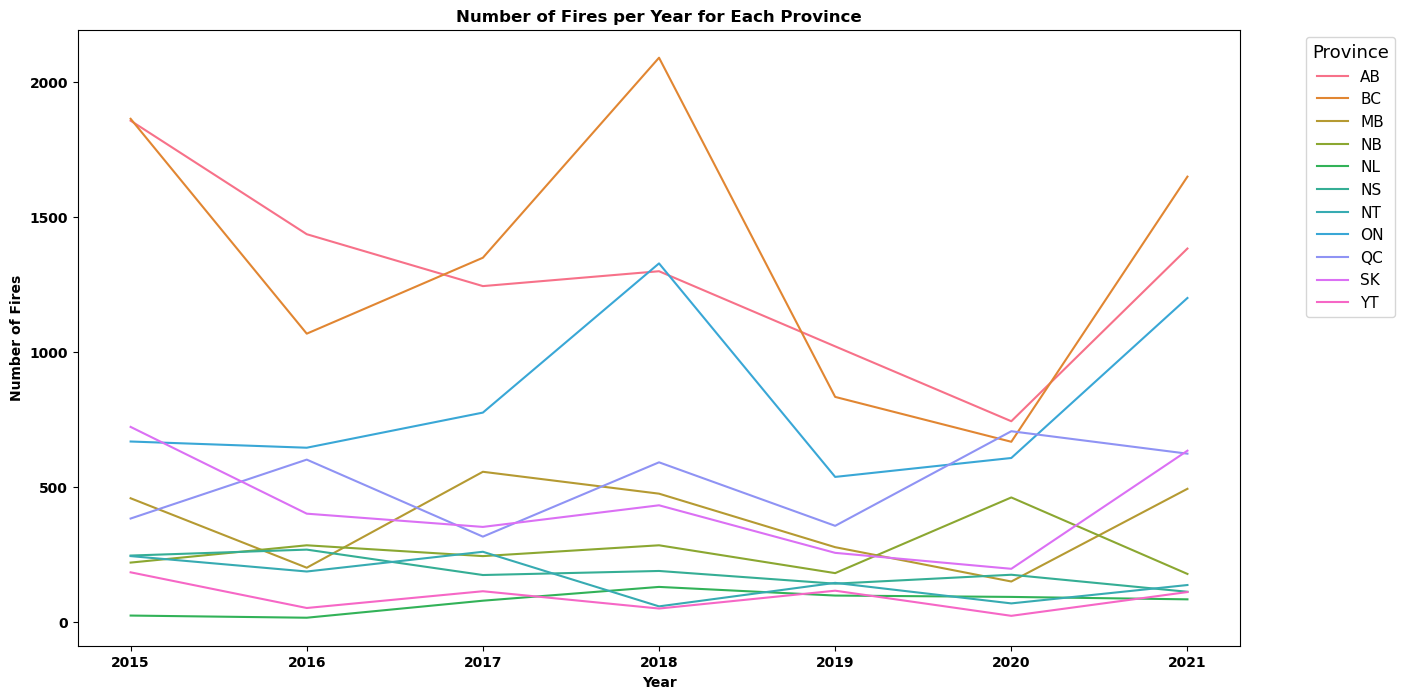

In [3]:
fire_counts = fire_data.groupby(['SRC_AGENCY', 'YEAR']).size().reset_index(name='Number of Fires')

# Set the size of the plot
plt.figure(figsize=(15, 8))

# Plotting a line chart for each province
sns.lineplot(data=fire_counts, x='YEAR', y='Number of Fires', hue='SRC_AGENCY')

# Adding plot title and labels with bold font
plt.title('Number of Fires per Year for Each Province', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Fires', fontweight='bold')
plt.legend(title='Province', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjusting tick parameters to make them bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Show the plot
plt.show()


#### Plot all fires for Quebec region on Folium

In [4]:
# Calculate the mean latitude and longitude for centering the map
center_lat = filtered_df_QC['LATITUDE'].mean()
center_lon = filtered_df_QC['LONGITUDE'].mean()

# Create a Folium map centered around the mean coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Iterate through the filtered dataset and add red dots to the map
for index, row in filtered_df_QC.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,  # Adjust the radius as needed
        color='red',  # Set the color to red
        fill=True,
        fill_color='red',  # Fill the circle with red color
        fill_opacity=0.7,  # Adjust the fill opacity as needed
        popup=row['SRC_AGENCY'],  # You can customize the popup content
    ).add_to(m)

file_path = './maps/1. quebec_fires_post_2015.html'
m.save(file_path)

m


#### Plotting number of fires by day of year for each year

In [ ]:
# Convert the 'REP_DATE' column to datetime
filtered_df_QC['REP_DATE'] = pd.to_datetime(filtered_df_QC['REP_DATE'])

# Extract the day of the year and add it as a new column 'DAY_OF_YEAR'
filtered_df_QC['DAY_OF_YEAR'] = filtered_df_QC['REP_DATE'].dt.dayofyear

filtered_df_QC = filtered_df_QC[filtered_df_QC['YEAR'] >= 2017]

# Group the data by 'YEAR' and 'DAY_OF_YEAR' and count the number of fires for each year and day
fires_per_year_day = filtered_df_QC.groupby(['YEAR', 'DAY_OF_YEAR']).size().unstack(fill_value=0)

fires_per_year_day_long = fires_per_year_day.reset_index().melt(id_vars='YEAR', var_name='DAY_OF_YEAR', value_name='Number of Fires')

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create the plot with a larger figure size
plt.figure(figsize=(15, 8))

# Using Seaborn to create a line plot for each year with specified aesthetics
sns.lineplot(
    data=fires_per_year_day_long, 
    x='DAY_OF_YEAR', 
    y='Number of Fires', 
    hue='YEAR', 
    marker='o', 
    linewidth=2.5, 
    markersize=5, 
    palette='tab10', 
    alpha=0.6
)

# Setting labels and title with bold font
plt.xlabel('Day of the Year', fontweight='bold')
plt.ylabel('Number of Fires', fontweight='bold')
plt.title('Number of Fires by Day of the Year (One Line per Year)', fontweight='bold')

# Enhancing the legend by moving it outside the plot area
plt.legend(title='Year', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjusting tick parameters to make them bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Show the plot
plt.show()


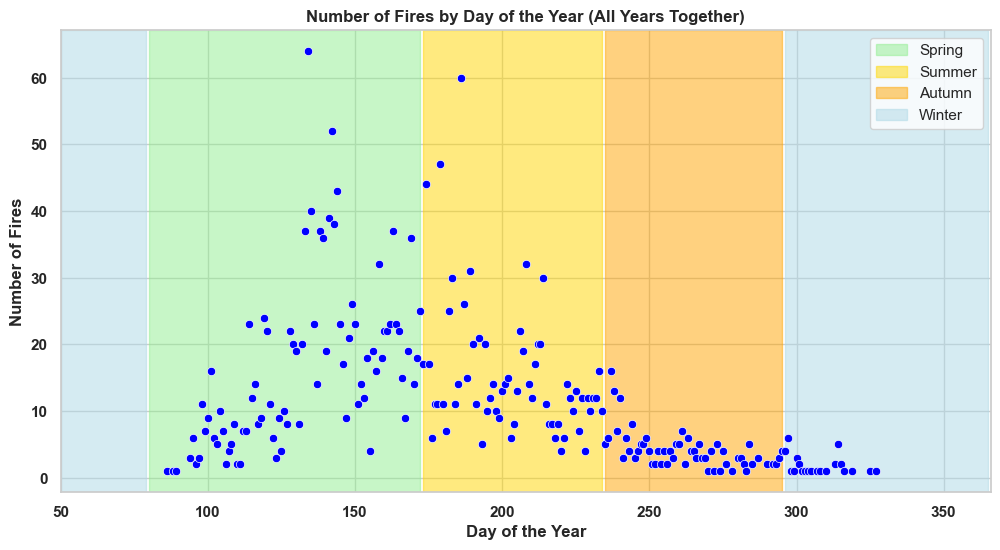

In [49]:
# Convert the 'REP_DATE' column to datetime
filtered_df_QC['REP_DATE'] = pd.to_datetime(filtered_df_QC['REP_DATE'])

# Extract the day of the year and add it as a new column 'DAY_OF_YEAR'
filtered_df_QC['DAY_OF_YEAR'] = filtered_df_QC['REP_DATE'].dt.dayofyear

# Group the data by 'DAY_OF_YEAR' and count the number of fires for each day
fires_per_day = filtered_df_QC.groupby('DAY_OF_YEAR').size().reset_index(name='Number of Fires')

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a line plot for all years together using Seaborn
plt.figure(figsize=(12, 6))

# Plot the points (fires) first with higher zorder
sns.scatterplot(data=fires_per_day, x='DAY_OF_YEAR', y='Number of Fires', marker='o', color='blue', zorder=2)

# Define the start and end days for each season
seasons = {
    'Spring': (80, 172),   # March 21st to June 20th
    'Summer': (173, 234),  # June 21st to August 22nd
    'Autumn': (235, 295),  # August 23rd to October 20th
    'Winter': [(1, 79), (296, 365)]  # January 1st to March 20th, and October 21st to December 31st (round way)
}

# Define corresponding colors for each season
season_colors = {
    'Spring': 'lightgreen',
    'Summer': 'gold',
    'Autumn': 'orange',
    'Winter': 'lightblue',
}

# Shade regions for each season with lower zorder
for season, date_ranges in seasons.items():
    if isinstance(date_ranges, tuple):
        date_ranges = [date_ranges]
    
    for start, end in date_ranges:
        # Check if Winter is added to the legend
        if season == 'Winter':
            label = 'Winter' if start == 1 else None  # Display "Winter" label for the first Winter period
        else:
            label = season
        
        plt.axvspan(start, end, alpha=0.5, color=season_colors[season], label=label, zorder=1)

# Setting labels and title
plt.xlabel('Day of the Year', fontweight='bold')
plt.ylabel('Number of Fires', fontweight='bold')
plt.title('Number of Fires by Day of the Year (All Years Together)', fontweight='bold')

# Adjusting tick parameters to make them bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Set x-axis limit to start from 50
plt.xlim(50, 366)

# Move the legend to the top right
plt.legend(loc='upper right')

# Show the plot
plt.show()

### Regression fit for the number of fires in all provinces after 2017

In [ ]:
filtered_data_2017 = fire_data[fire_data['YEAR'] >= 2017]

# Convert the 'REP_DATE' column to datetime
filtered_data_2017['REP_DATE'] = pd.to_datetime(filtered_data_2017['REP_DATE'])

# Extract the day of the year and add it as a new column 'DAY_OF_YEAR'
filtered_data_2017['DAY_OF_YEAR'] = filtered_data_2017['REP_DATE'].dt.dayofyear

# Group the data by 'SRC_AGENCY' and 'DAY_OF_YEAR' and count the number of fires for each day
fires_per_day_province = filtered_data_2017.groupby(['SRC_AGENCY', 'DAY_OF_YEAR']).size().reset_index(name='NUM_FIRES')

# Set up the plot
plt.figure(figsize=(12, 6))

# Fit a cubic regression for each province and plot
for province, data in fires_per_day_province.groupby('SRC_AGENCY'):
    # Fit a cubic regression to the data
    coefficients = np.polyfit(data['DAY_OF_YEAR'], data['NUM_FIRES'], 3)
    cubic_fit = np.poly1d(coefficients)
    
    # Generate a range of days for plotting the fit
    day_range = np.linspace(data['DAY_OF_YEAR'].min(), data['DAY_OF_YEAR'].max(), 100)
    
    # Plot the cubic fit
    plt.plot(day_range, cubic_fit(day_range), label=f'{province} Cubic Fit')

plt.xlabel('Day of the Year')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Day of the Year with Regression Fit (After 2017)')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Voxel Creation

In [20]:
# Define the center coordinates (CONFIGURABLE)
center_lat = 47.593339597061444  # Center latitude in degrees
center_lon = -73.65612140436465  # Center longitude in degrees 

# Convert the 100 km distance to degrees (approximate values, can vary depending on location)
degrees_per_km = 1 / 111.32  # Approximate latitude degrees per kilometer
radius_km = 250  # Half of the desired region's side length in kilometers

# Calculate latitude and longitude boundaries for the region
min_lat = center_lat - (radius_km * degrees_per_km)
max_lat = center_lat + (radius_km * degrees_per_km)
min_lon = center_lon - (radius_km * degrees_per_km)
max_lon = center_lon + (radius_km * degrees_per_km)

# Filter the dataset to include only data within the specified region
filtered_region_df = filtered_df_QC[
    (filtered_df_QC['LATITUDE'] >= min_lat) &
    (filtered_df_QC['LATITUDE'] <= max_lat) &
    (filtered_df_QC['LONGITUDE'] >= min_lon) &
    (filtered_df_QC['LONGITUDE'] <= max_lon)
]

In [ ]:
# Create a map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Define the coordinates for the boundary of the region
boundary_coords = [
    [min_lat, min_lon],
    [min_lat, max_lon],
    [max_lat, max_lon],
    [max_lat, min_lon],
    [min_lat, min_lon]  # Close the polygon by returning to the starting point
]

# Add the boundary polygon to the map
folium.PolyLine(locations=boundary_coords, color='blue').add_to(m)

# Iterate through the filtered dataset and add markers for each data point within the region
for index, row in filtered_region_df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,  # Adjust the radius as needed
        color='red',  # Set the color to red
        fill=True,
        fill_color='red',  # Fill the circle with red color
        fill_opacity=0.7,  # Adjust the fill opacity as needed
        popup=row['SRC_AGENCY'],  # You can customize the popup content
    ).add_to(m)

file_path = './maps/2. spatial_boundary.html'
m.save(file_path)

# Display the map
m

## Spatial Analysis (x, y)

#### Show the voxels which have had the fires

In [ ]:
# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats = np.arange(min_lat, max_lat, voxel_size_degrees)
lons = np.arange(min_lon, max_lon, voxel_size_degrees)

# Create a DataFrame to represent the voxels
voxel_df = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats[:-1], lats[1:]):
    for lon_start, lon_end in zip(lons[:-1], lons[1:]):
        # Filter the dataset for the current voxel's spatial boundary
        voxel_data = filtered_df_QC[
            (filtered_df_QC['LATITUDE'] >= lat_start) &
            (filtered_df_QC['LATITUDE'] < lat_end) &
            (filtered_df_QC['LONGITUDE'] >= lon_start) &
            (filtered_df_QC['LONGITUDE'] < lon_end)
        ]
        
        # Check if there's any fire occurrence in the current voxel
        fire_occurred = len(voxel_data) > 0
        
        # Append the voxel's information to the DataFrame
        voxel_df = voxel_df.append({
            'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
            'LONGITUDE': (lon_start + lon_end) / 2,
            'Y': int(fire_occurred)
        }, ignore_index=True)
        
        # Define the box boundaries for visualization
        box = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start],
            [lat_start, lon_start]
        ]
        boxes.append(box)

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel
for box in boxes:
    folium.PolyLine(locations=box, color='blue').add_to(m)

# Iterate through the voxel DataFrame and add markers for each voxel with fire occurrence
for index, row in voxel_df[voxel_df['Y'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,  # Adjust the radius as needed
        color='red',  # Set the color to red
        fill=True,
        fill_color='red',  # Fill the circle with red color
        fill_opacity=0.7,  # Adjust the fill opacity as needed
    ).add_to(m)

file_path = './maps/3. spatial_voxels.html'
m.save(file_path)

# Display the map
m

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees_lr = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats_lr = np.arange(min_lat, max_lat, voxel_size_degrees_lr)
lons_lr = np.arange(min_lon, max_lon, voxel_size_degrees_lr)

# Create a DataFrame to represent the voxels
voxel_df_lr = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats_lr[:-1], lats_lr[1:]):
    for lon_start, lon_end in zip(lons_lr[:-1], lons_lr[1:]):
        # Filter the dataset for the current voxel's spatial boundary
        voxel_data = filtered_df_QC[
            (filtered_df_QC['LATITUDE'] >= lat_start) &
            (filtered_df_QC['LATITUDE'] < lat_end) &
            (filtered_df_QC['LONGITUDE'] >= lon_start) &
            (filtered_df_QC['LONGITUDE'] < lon_end)
        ]
        
        # Check if there's any fire occurrence in the current voxel
        fire_occurred = len(voxel_data) > 0
        
        # Append the voxel's information to the DataFrame
        voxel_df_lr = voxel_df_lr.append({
            'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
            'LONGITUDE': (lon_start + lon_end) / 2,
            'Y': int(fire_occurred)
        }, ignore_index=True)
        
        # Define the box boundaries for visualization
        box = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start],
            [lat_start, lon_start]
        ]
        boxes.append(box)

# Split the data into training and testing sets
X = voxel_df_lr[['LATITUDE', 'LONGITUDE']]
y = voxel_df_lr['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Predict the probabilities of fire occurrence for each voxel
voxel_df_lr['Probability'] = logreg_model.predict_proba(X)[:, 1]

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel with colors based on predicted probabilities and tooltips showing the probability
for box, probability in zip(boxes, voxel_df_lr['Probability']):
    color = f'rgba(255, 0, 0, {probability})'  # Red color with alpha based on probability
    folium.Polygon(locations=box, color=color, fill_color=color, fill_opacity=0.7,
                    tooltip=f'Probability: {probability:.2f}').add_to(m)

# Save the map to an HTML file
file_path = './maps/4. lr_spatial_model.html'
m.save(file_path)

m

### Why Logistic Regression is bad?

The Random Forest model is producing a more granular and perhaps more nuanced set of probability predictions across the geographical space than the Logistic Regression model.

Logistic Regression is a linear model that may oversimplify the relationship between latitude/longitude and fire occurrence, which is likely to be non-linear and influenced by a multitude of factors beyond just location.

Logistic Regression assumes a linear relationship in the log-odds scale, which might not hold true in the spatial context of fire distribution.

Non-Linear Boundaries: Random Forest is capable of modeling complex, non-linear decision boundaries, which is often necessary for spatial data that have complex relationships. Logistic Regression, on the other hand, assumes a linear decision boundary, which might be too simplistic for the distribution of fires across a geographic area.

## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees_dt = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats_dt = np.arange(min_lat, max_lat, voxel_size_degrees_dt)
lons_dt = np.arange(min_lon, max_lon, voxel_size_degrees_dt)

# Create a DataFrame to represent the voxels
voxel_df_dt = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats_dt[:-1], lats_dt[1:]):
    for lon_start, lon_end in zip(lons_dt[:-1], lons_dt[1:]):
        # Filter the dataset for the current voxel's spatial boundary
        voxel_data = filtered_df_QC[
            (filtered_df_QC['LATITUDE'] >= lat_start) &
            (filtered_df_QC['LATITUDE'] < lat_end) &
            (filtered_df_QC['LONGITUDE'] >= lon_start) &
            (filtered_df_QC['LONGITUDE'] < lon_end)
        ]
        
        # Check if there's any fire occurrence in the current voxel
        fire_occurred = len(voxel_data) > 0
        
        # Append the voxel's information to the DataFrame
        voxel_df_dt = voxel_df_dt.append({
            'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
            'LONGITUDE': (lon_start + lon_end) / 2,
            'Y': int(fire_occurred)
        }, ignore_index=True)
        
        # Define the box boundaries for visualization
        box = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start],
            [lat_start, lon_start]
        ]
        boxes.append(box)

# Split the data into training and testing sets
X = voxel_df_dt[['LATITUDE', 'LONGITUDE']]
y = voxel_df_dt['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# # Train a Logistic Regression model
# logreg_model = LogisticRegression(random_state=42)
# logreg_model.fit(X_train, y_train)

# Predict the probabilities of fire occurrence for each voxel
voxel_df_dt['Probability'] = dt_model.predict_proba(X)[:, 1]

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel with colors based on predicted probabilities and tooltips showing the probability
for box, probability in zip(boxes, voxel_df_dt['Probability']):
    color = f'rgba(255, 0, 0, {probability})'  # Red color with alpha based on probability
    folium.Polygon(locations=box, color=color, fill_color=color, fill_opacity=0.7,
                    tooltip=f'Probability: {probability:.2f}').add_to(m)

# Save the map to an HTML file
file_path = './maps/5. dt_spatial_model.html'
m.save(file_path)

m

### Why Decision Trees are bad?

Decision Trees make predictions based on the majority class of the samples in a leaf node. If all the samples in a leaf node are from the same class, the predicted probability for that class will be 1, and 0 for the other class.

If the tree has overfit the training data, it might have learned to perfectly classify the samples in the training set, leading to leaf nodes that are completely pure.

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees_gb = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats_gb = np.arange(min_lat, max_lat, voxel_size_degrees_gb)
lons_gb = np.arange(min_lon, max_lon, voxel_size_degrees_gb)

# Create a DataFrame to represent the voxels
voxel_df_gb = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats_gb[:-1], lats_gb[1:]):
    for lon_start, lon_end in zip(lons_gb[:-1], lons_gb[1:]):
        # Filter the dataset for the current voxel's spatial boundary
        voxel_data = filtered_df_QC[
            (filtered_df_QC['LATITUDE'] >= lat_start) &
            (filtered_df_QC['LATITUDE'] < lat_end) &
            (filtered_df_QC['LONGITUDE'] >= lon_start) &
            (filtered_df_QC['LONGITUDE'] < lon_end)
        ]
        
        # Check if there's any fire occurrence in the current voxel
        fire_occurred = len(voxel_data) > 0
        
        # Append the voxel's information to the DataFrame
        voxel_df_gb = voxel_df_gb.append({
            'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
            'LONGITUDE': (lon_start + lon_end) / 2,
            'Y': int(fire_occurred)
        }, ignore_index=True)
        
        # Define the box boundaries for visualization
        box = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start],
            [lat_start, lon_start]
        ]
        boxes.append(box)

# Split the data into training and testing sets
X = voxel_df_gb[['LATITUDE', 'LONGITUDE']]
y = voxel_df_gb['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict the probabilities of fire occurrence for each voxel
voxel_df_gb['Probability'] = gb_model.predict_proba(X)[:, 1]

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel with colors based on predicted probabilities and tooltips showing the probability
for box, probability in zip(boxes, voxel_df_gb['Probability']):
    color = f'rgba(255, 0, 0, {probability})'  # Red color with alpha based on probability
    folium.Polygon(locations=box, color=color, fill_color=color, fill_opacity=0.7,
                    tooltip=f'Probability: {probability:.2f}').add_to(m)

# Save the map to an HTML file
file_path = './maps/5. gb_spatial_model.html'
m.save(file_path)

m

#### Spatial Model Accuracy using Gradient Boosting

In [32]:
# Predicting on the test data
y_pred = gb_model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.77
Precision: 0.67
Recall: 0.32
F1 Score: 0.43


### Using GridSearchCV to tune the hyper parameters for Gradient Boosting 

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0]
}

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_gb_model = grid_search.best_estimator_

# Now you can use best_gb_model to predict probabilities and expect them to be more accurate
voxel_df_gb['Tuned_Probability'] = best_gb_model.predict_proba(X)[:, 1]

In [35]:
best_gb_model

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_split=4,
                           n_estimators=200, random_state=42, subsample=0.9)

In [36]:
# Predicting on the test data
y_pred = best_gb_model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.74
Recall: 0.33
F1 Score: 0.46


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats = np.arange(min_lat, max_lat, voxel_size_degrees)
lons = np.arange(min_lon, max_lon, voxel_size_degrees)

# Create a DataFrame to represent the voxels
voxel_df = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats[:-1], lats[1:]):
    for lon_start, lon_end in zip(lons[:-1], lons[1:]):
        # Filter the dataset for the current voxel's spatial boundary
        voxel_data = filtered_df_QC[
            (filtered_df_QC['LATITUDE'] >= lat_start) &
            (filtered_df_QC['LATITUDE'] < lat_end) &
            (filtered_df_QC['LONGITUDE'] >= lon_start) &
            (filtered_df_QC['LONGITUDE'] < lon_end)
        ]
        
        # Check if there's any fire occurrence in the current voxel
        fire_occurred = len(voxel_data) > 0
        
        # Append the voxel's information to the DataFrame
        voxel_df = voxel_df.append({
            'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
            'LONGITUDE': (lon_start + lon_end) / 2,
            'Y': int(fire_occurred)
        }, ignore_index=True)
        
        # Define the box boundaries for visualization
        box = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start],
            [lat_start, lon_start]
        ]
        boxes.append(box)

# Split the data into training and testing sets
X = voxel_df[['LATITUDE', 'LONGITUDE']]
y = voxel_df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict the probabilities of fire occurrence for each voxel
voxel_df['Probability'] = rf_model.predict_proba(X)[:, 1]

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel with colors based on predicted probabilities and tooltips showing the probability
for box, probability in zip(boxes, voxel_df['Probability']):
    color = f'rgba(255, 0, 0, {probability})'  # Red color with alpha based on probability
    folium.PolyLine(locations=box, color=color, fill_color=color, fill_opacity=0.7,
                    tooltip=f'Probability: {probability:.2f}').add_to(m)

file_path = './maps/5. rf_spatial_model.html'
m.save(file_path)

# Display the map
m

#### Spatial Model Accuracy using Random Forest 

In [13]:
# Predicting on the test data
y_pred = rf_model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.63
Recall: 0.53
F1 Score: 0.57


### Using GridSearchCV to tune the hyper parameters for Random Forest

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Initialize the base model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Find the best model
best_rf_model = grid_search.best_estimator_

# Use the best model for predictions or further analysis
voxel_df_gb['Tuned_RF_Probability'] = best_rf_model.predict_proba(X)[:, 1]

best_rf_model

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_f

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_fea

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_feat

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_fe

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_feat

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_featu

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jatin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=4,
                       n_estimators=500, random_state=42)

In [38]:
# Predicting on the test data
y_pred = best_rf_model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.77
Recall: 0.35
F1 Score: 0.48
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimato

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_d

### Making prediction for co-ordinates using the Spatial Random Forest Model

In [14]:
input_data = pd.DataFrame({
    'LATITUDE': [45.163344],
    'LONGITUDE': [-73.611656]
})

predicted_probability = rf_model.predict_proba(input_data)[:, 1][0]

print(f"The probability of fire occurrence at the given coordinates is: {predicted_probability:.2f}")


The probability of fire occurrence at the given coordinates is: 0.57


## Spatial & Temporal Analysis (x, y, d)

In [ ]:
# Define the center coordinates (adjust as needed)
center_lat = 45.5  # Center latitude in degrees
center_lon = -73.5  # Center longitude in degrees

# Convert the 100 km distance to degrees (approximate values, can vary depending on location)
degrees_per_km = 1 / 111.32  # Approximate latitude degrees per kilometer
radius_km = 50  # Half of the desired region's side length in kilometers

# Calculate latitude and longitude boundaries for the region
min_lat = center_lat - (radius_km * degrees_per_km)
max_lat = center_lat + (radius_km * degrees_per_km)
min_lon = center_lon - (radius_km * degrees_per_km)
max_lon = center_lon + (radius_km * degrees_per_km)

# Define the voxel size in degrees (10 km by 10 km)
voxel_size_degrees = 0.09  # Approximately 10 km

# Create a grid of voxel coordinates
lats = np.arange(min_lat, max_lat, voxel_size_degrees)
lons = np.arange(min_lon, max_lon, voxel_size_degrees)

# Create a DataFrame to represent the voxels
voxel_df_2 = pd.DataFrame(columns=['LATITUDE', 'LONGITUDE', 'DAY_OF_YEAR', 'Y'])

# Create a list to store box boundaries
boxes = []

# Iterate through the grid and set Y = 1 if there has been a fire in that voxel, otherwise set Y = 0
for lat_start, lat_end in zip(lats[:-1], lats[1:]):
    for lon_start, lon_end in zip(lons[:-1], lons[1:]):
        for day in range(1, 366):
            # Filter the dataset for the current voxel's spatial boundary
            voxel_data = filtered_df_QC[
                (filtered_df_QC['LATITUDE'] >= lat_start) &
                (filtered_df_QC['LATITUDE'] < lat_end) &
                (filtered_df_QC['LONGITUDE'] >= lon_start) &
                (filtered_df_QC['LONGITUDE'] < lon_end) &
                (filtered_df_QC['DAY_OF_YEAR'] == day)
            ]

            # Check if there's any fire occurrence in the current voxel
            fire_occurred = len(voxel_data) > 0

            # Append the voxel's information to the DataFrame
            voxel_df_2 = voxel_df_2.append({
                'LATITUDE': (lat_start + lat_end) / 2,  # Use the voxel's center
                'LONGITUDE': (lon_start + lon_end) / 2,
                'DAY_OF_YEAR': day,
                'Y': int(fire_occurred)
            }, ignore_index=True)

            # Define the box boundaries for visualization
            box = [
                [lat_start, lon_start],
                [lat_start, lon_end],
                [lat_end, lon_end],
                [lat_end, lon_start],
                [lat_start, lon_start]
            ]
            boxes.append(box)

# Create a Folium map centered around the specified coordinates (center_lat, center_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add boxes for each voxel
for box in boxes:
    folium.PolyLine(locations=box, color='blue').add_to(m)

# Iterate through the voxel DataFrame and add markers for each voxel with fire occurrence
for index, row in voxel_df_2[voxel_df_2['Y'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,  # Adjust the radius as needed
        color='red',  # Set the color to red
        fill=True,
        fill_color='red',  # Fill the circle with red color
        fill_opacity=0.7,  # Adjust the fill opacity as needed
    ).add_to(m)
             
file_path = './maps/spatial_temporal_voxel.html'
m.save(file_path)

# Display the map
m

### Training Random Forest for Spatial & Temporal Probabilities -

In [16]:
# Split the data into training and testing sets
X = voxel_df_2[['LATITUDE', 'LONGITUDE', 'DAY_OF_YEAR']]
y = voxel_df_2['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model_2 = RandomForestClassifier(random_state=42)
rf_model_2.fit(X_train, y_train)

# Predict the probabilities of fire occurrence for each voxel
voxel_df_2['Probability'] = rf_model_2.predict_proba(X)[:, 1]

### Making prediction for co-ordinates & day of year using the above trained model

In [17]:
# Step 1: Prepare the Input Data
input_data_2 = pd.DataFrame({
    'LATITUDE': [45.163344],
    'LONGITUDE': [-73.611656],
    'DAY_OF_YEAR': 149.0
})

# Step 2: Predict the Probability
predicted_probability = rf_model_2.predict_proba(input_data_2)[:, 1][0]

# Print the probability
print(f"The probability of fire occurrence at the given coordinates is: {predicted_probability:.2f}")


The probability of fire occurrence at the given coordinates is: 0.62
